In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from pandas import concat
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    return scaler, data_scaled

In [3]:
def inverse_normdata(scaler, dataX, yhat):
    dataX = dataX.reshape((dataX.shape[0], dataX.shape[2]))
    inv_y = np.concatenate((dataX, yhat), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, -1]
    return inv_y

In [4]:
def calculate_mape(actual, predicted):
    absolute_errors = np.abs(actual - predicted)
    percentage_errors = absolute_errors / actual
    mape = np.mean(percentage_errors) * 100
    return mape

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
def build_model_ann(train_X):
    model = Sequential()

    model.add(Dense(256, activation='relu', input_shape=(train_X.shape[1],)))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mse', optimizer='adam')

    return model

In [7]:
data = pd.read_csv("shenzhen.csv")

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
data.set_index('datetime', inplace=True)
data.head()

,price
datetime,
2015-05-18,37.800
2015-05-19,39.700
2015-05-20,38.050
2015-05-21,41.400
2015-05-22,41.215


In [10]:
data_reframed = series_to_supervised(data, 1, 1)
df_data_reframed = pd.DataFrame(data_reframed)

In [11]:
scaler, data_scaled = normalize_data(data_reframed.values)
df_data_scaled = pd.DataFrame(data_scaled, index=df_data_reframed.index, columns=df_data_reframed.columns)

df_data_scaled = df_data_scaled.drop(df_data_scaled[df_data_scaled.index.year == 2024].index)

test = df_data_scaled.iloc[:382]
train = df_data_scaled.iloc[382:]

print(train)

            var1(t-1)   var1(t)
datetime                       
2016-12-05   0.323550  0.346576
2016-12-06   0.346576  0.355263
2016-12-07   0.355263  0.259459
2016-12-08   0.259459  0.350151
2016-12-09   0.350151  0.305678
...               ...       ...
2023-02-20   0.830752  0.830752
2023-02-21   0.830752  0.830752
2023-02-22   0.830752  0.743136
2023-02-23   0.743136  0.821110
2023-02-24   0.821110  0.827427

[1518 rows x 2 columns]


In [13]:
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape)


train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)

print(type(train_X))
print(type(train_y))
print(type(test_X))
print(type(test_y))

print("train_X shape = %s, train_y shape = %s, test_X shape = %s, test_y shape = %s" % (train_X.shape, train_y.shape, test_X.shape, test_y.shape))

(1518, 1, 1)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
train_X shape = (1518, 1, 1), train_y shape = (1518, 1), test_X shape = (382, 1, 1), test_y shape = (382, 1)


f:\OprecAdminMCI2024\drive-download-20240404T140626Z-001\Dataset Penugasan\myvenv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0330 - val_loss: 0.2096
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0545 - val_loss: 0.0447
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - val_loss: 0.0103
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0063
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0037
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

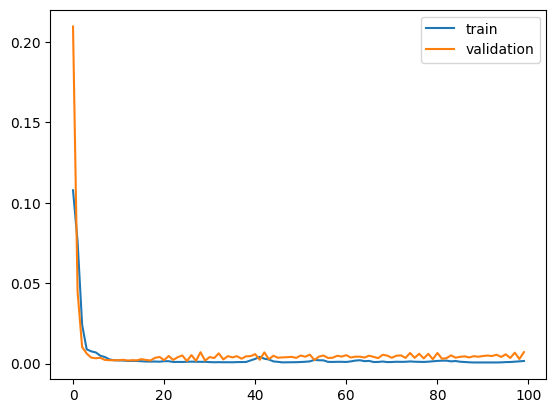

In [14]:
model_ann = build_model_ann(train_X)

history = model_ann.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)
model_ann.save("ann_model_ann.h5")

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
The R2 score on the Train set is:	0.920
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The R2 score on the Test set is:	0.394


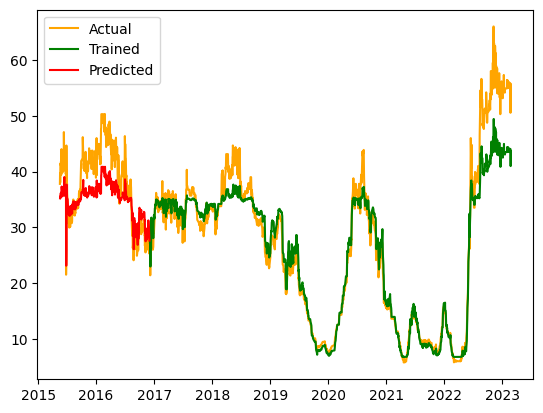

Test RMSE normal : 5.097
Test MSE normal : 25.977
MAPE: 10.537221469273113 %


In [15]:
y_train_pred = model_ann.predict(train_X)
r2_ann = r2_score(train_y, y_train_pred)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, y_train_pred)))
inv_ymodel_rnn = inverse_normdata(scaler, train_X, y_train_pred)
df_inv_ymodel_rnn = pd.DataFrame(inv_ymodel_rnn, index=train_y.index)

y_test_pred = model_ann.predict(test_X)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, y_test_pred)))
inv_y_test = inverse_normdata(scaler, test_X, y_test_pred)

df_inv_ytest = pd.DataFrame(inv_y_test, index=test_y.index)
plt.plot(data, color='orange', label='Actual')
plt.plot(df_inv_ymodel_rnn, color='green', label='Trained')
plt.plot(df_inv_ytest, color='red', label='Predicted')
plt.legend()
plt.show()

inv_test_y = inverse_normdata(scaler, test_X, test_y)
rmse_normal = sqrt(mean_squared_error(inv_test_y, inv_y_test))
mape_normal = calculate_mape(inv_test_y, inv_y_test)
print('Test RMSE normal : %.3f' % rmse_normal)
mse_ann = mean_squared_error(inv_test_y, inv_y_test)
print('Test MSE normal : %.3f' % mean_squared_error(inv_test_y, inv_y_test))
mape_ann = calculate_mape(inv_test_y, inv_y_test)
print("MAPE:", mape_ann, "%")

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
import numpy as np

from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import Sequential

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [17]:
def build_model_rnn(train_X):
    model = Sequential()

    model.add(SimpleRNN(256, input_shape=(train_X.shape[2], train_X.shape[1]), return_sequences=True))
    model.add(Dropout(0.5))

    model.add(SimpleRNN(512, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(SimpleRNN(512, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(loss="mse", optimizer="adam")

    return model

In [18]:
def build_model_lstm(train_X):
    model = Sequential()

    model.add(LSTM(256, input_shape=(train_X.shape[2], train_X.shape[1]), return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    model.compile(loss="mse", optimizer="adam")

    return model

f:\OprecAdminMCI2024\drive-download-20240404T140626Z-001\Dataset Penugasan\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0275 - val_loss: 0.1595
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0704 - val_loss: 0.0027
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

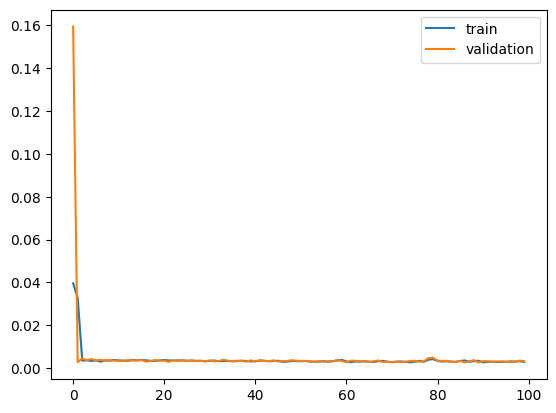

In [19]:
model_rnn = build_model_rnn(train_X)

history = model_rnn.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)
model_rnn.save("rnn_model_rnn.h5")

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
The R2 score on the Train set is:	0.951
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The R2 score on the Test set is:	0.730


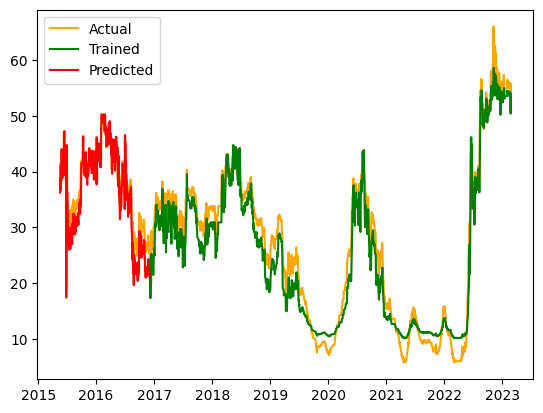

Test RMSE normal : 3.399
Test MSE normal : 11.556
MAPE: 7.376746531749155 %


In [20]:
y_train_pred = model_rnn.predict(train_X)
r2_rnn = r2_score(train_y, y_train_pred)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, y_train_pred)))
inv_ymodel_rnn = inverse_normdata(scaler, train_X, y_train_pred)
df_inv_ymodel_rnn = pd.DataFrame(inv_ymodel_rnn, index=train_y.index)
# plot test data
y_test_pred = model_rnn.predict(test_X)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, y_test_pred)))
inv_y_test = inverse_normdata(scaler, test_X, y_test_pred)

df_inv_ytest = pd.DataFrame(inv_y_test, index=test_y.index)
plt.plot(data, color='orange', label='Actual')
plt.plot(df_inv_ymodel_rnn, color='green', label='Trained')
plt.plot(df_inv_ytest, color='red', label='Predicted')
plt.legend()
plt.show()

# inverse data dari 0-1 menjadi range awal
inv_test_y = inverse_normdata(scaler, test_X, test_y)
rmse_normal = sqrt(mean_squared_error(inv_test_y, inv_y_test))
mape_normal = calculate_mape(inv_test_y, inv_y_test)
print('Test RMSE normal : %.3f' % rmse_normal)
mse_rnn = mean_squared_error(inv_test_y, inv_y_test)
print('Test MSE normal : %.3f' % mean_squared_error(inv_test_y, inv_y_test))
mape_rnn = calculate_mape(inv_test_y, inv_y_test)
print("MAPE:", mape_rnn, "%")

f:\OprecAdminMCI2024\drive-download-20240404T140626Z-001\Dataset Penugasan\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0281 - val_loss: 0.1870
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0559 - val_loss: 0.0347
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0189 - val_loss: 0.0388
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0101 - val_loss: 0.0038
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step

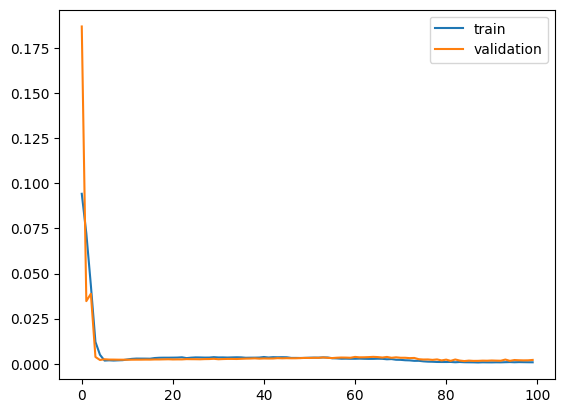

In [21]:
model_lstm = build_model_lstm(train_X)

history = model_lstm.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)
model_lstm.save("rnn_model_lstm.h5")

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
The R2 score on the Train set is:	0.987
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
The R2 score on the Test set is:	0.821


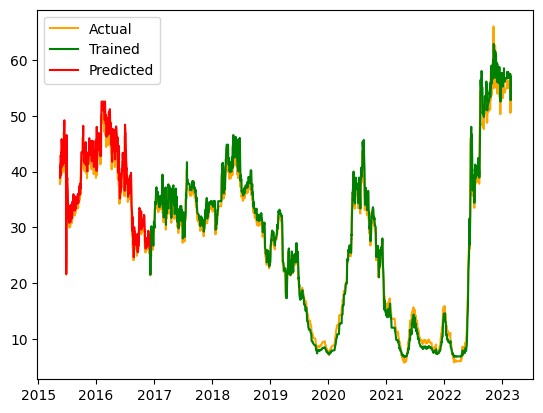

Test RMSE normal : 2.774
Test MSE normal : 7.693
MAPE: 5.260999429098139 %


In [22]:
y_train_pred_lstm = model_lstm.predict(train_X)
r2_lstm = r2_score(train_y, y_train_pred_lstm)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, y_train_pred_lstm)))
inv_ymodel_lstm = inverse_normdata(scaler, train_X, y_train_pred_lstm)
df_inv_ymodel_lstm = pd.DataFrame(inv_ymodel_lstm, index=train_y.index)

y_test_pred_lstm = model_lstm.predict(test_X)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, y_test_pred_lstm)))
inv_y_test = inverse_normdata(scaler, test_X, y_test_pred_lstm)

df_inv_ytest = pd.DataFrame(inv_y_test, index=test_y.index)
plt.plot(data, color='orange', label='Actual')
plt.plot(df_inv_ymodel_lstm, color='green', label='Trained')
plt.plot(df_inv_ytest, color='red', label='Predicted')
plt.legend()
plt.show()

inv_test_y = inverse_normdata(scaler, test_X, test_y)
rmse_normal = sqrt(mean_squared_error(inv_test_y, inv_y_test))
mse_lstm = mean_squared_error(inv_test_y, inv_y_test)
print('Test RMSE normal : %.3f' % rmse_normal)
print('Test MSE normal : %.3f' % mean_squared_error(inv_test_y, inv_y_test))
mape_lstm = calculate_mape(inv_test_y, inv_y_test)
print("MAPE:", mape_lstm, "%")

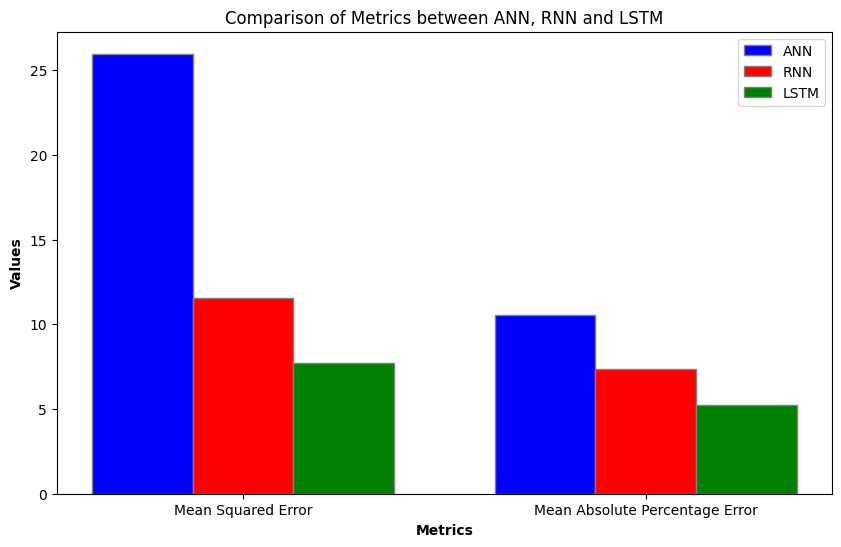

In [23]:
metrics = ['Mean Squared Error', 'Mean Absolute Percentage Error']
ann_values = [mse_ann, mape_ann]
rnn_values = [mse_rnn, mape_rnn]
lstm_values = [mse_lstm, mape_lstm]
plt.figure(figsize=(10, 6))
bar_width = 0.25
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
plt.bar(r1, ann_values, color='b', width=bar_width, edgecolor='grey', label='ANN')
plt.bar(r2, rnn_values, color='r', width=bar_width, edgecolor='grey', label='RNN')
plt.bar(r3, lstm_values, color='g', width=bar_width, edgecolor='grey', label='LSTM')
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Values', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(metrics))], metrics)
plt.title('Comparison of Metrics between ANN, RNN and LSTM')
plt.legend()
plt.show()

# print(type(r2_ann))
# print(type(r2_rnn))
# print(type(mse_ann))
# print(type(mse_rnn))
# print(type(mape_ann))
# print(type(mape_rnn))

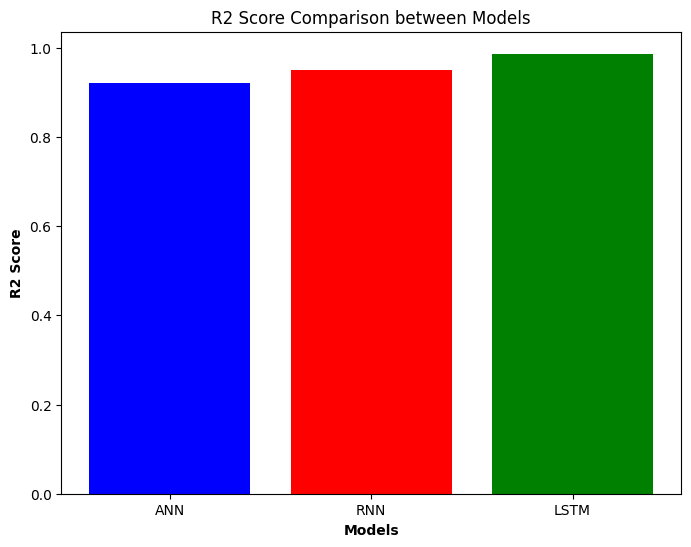

In [24]:
models = ['ANN', 'RNN', 'LSTM']
r2_scores = [r2_ann, r2_rnn, r2_lstm]
plt.figure(figsize=(8, 6))
plt.bar(models, r2_scores, color=['blue', 'red', 'green'])
plt.xlabel('Models', fontweight='bold')
plt.ylabel('R2 Score', fontweight='bold')
plt.title('R2 Score Comparison between Models')
plt.show()